# Housing Value and Unemployment: Is there a Correlation?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from src.cleaning import DataCleaner
import openpyxl

In [2]:
# initialize data cleaner class, insert file paths to raw data sets
data_cleaner = DataCleaner('data/raw/hpi_po_metro.csv', 'data/raw/ssamatab1.csv')

# clean unemployment data set
data_cleaner.clean_unemployment_data

# clean housing data set
clean_housing_data = data_cleaner.clean_housing_data

# 
clean_unemployment_data = data_cleaner.clean_unemployment_data

In [3]:
# Group the data to create to make it relatable to each other.

grouped_housing_data = clean_housing_data.drop(columns=['Quarter','Not_Seasonally_Adjusted_Index'] ).groupby(['CBSA', 'Metro_Name', 'Year']).agg('mean').reset_index()

grouped_unemployment_data = clean_unemployment_data.drop(columns="Month").groupby(
    ['LAUS_Code', 'State_FIPS_Code','FIPS_Code', 'Area', 'Year']).agg('mean').round(2).reset_index()
grouped_unemployment_data["Unemployment_Rate"] = grouped_unemployment_data["Unemployment_Rate"] / 10

In [4]:
# make SQL database with tables "Unemployment" and "Housing_value"

with sqlite3.connect("database.db") as conn:
    grouped_unemployment_data.to_sql("Unemployment", conn, if_exists='replace', index=False)
    grouped_housing_data.to_sql("Housing_value", conn, if_exists='replace', index=False)

In [5]:
# grouped_housing_data.to_excel('data/grouped_housing_data.xlsx', engine="openpyxl", index=False)
# grouped_unemployment_data.to_excel('data/grouped_unemployment_data.xlsx', engine="openpyxl", index=False)
# # combined_tables_result.to_excel(excel_writer="data/combined_tables_result.xlsx", index=False, engine="openpyxl")

In [6]:
combined_tables_query = """

SELECT 
    Unemployment.LAUS_Code AS Unemployment_LAUS_Code,
    Unemployment.Year AS Unemployment_Year,
    Unemployment.Area AS Unemployment_Area,
    Unemployment.Employment AS Employment,
    Unemployment.Unemployment AS Unemployment,
    Unemployment.Unemployment_Rate AS Unemployment_Rate,
    Housing_value.Metro_Name AS Housing_value_Metro_Name,
    Housing_value.Seasonally_Adjusted_Index AS Housing_value_Seasonally_Adjusted_Index
FROM Unemployment
INNER JOIN Housing_value
    ON Unemployment.FIPS_Code = Housing_value.CBSA
    AND Unemployment.Year = Housing_value.Year
"""

combined_tables_result = pd.read_sql(combined_tables_query, conn)

# Correlation Across the United States

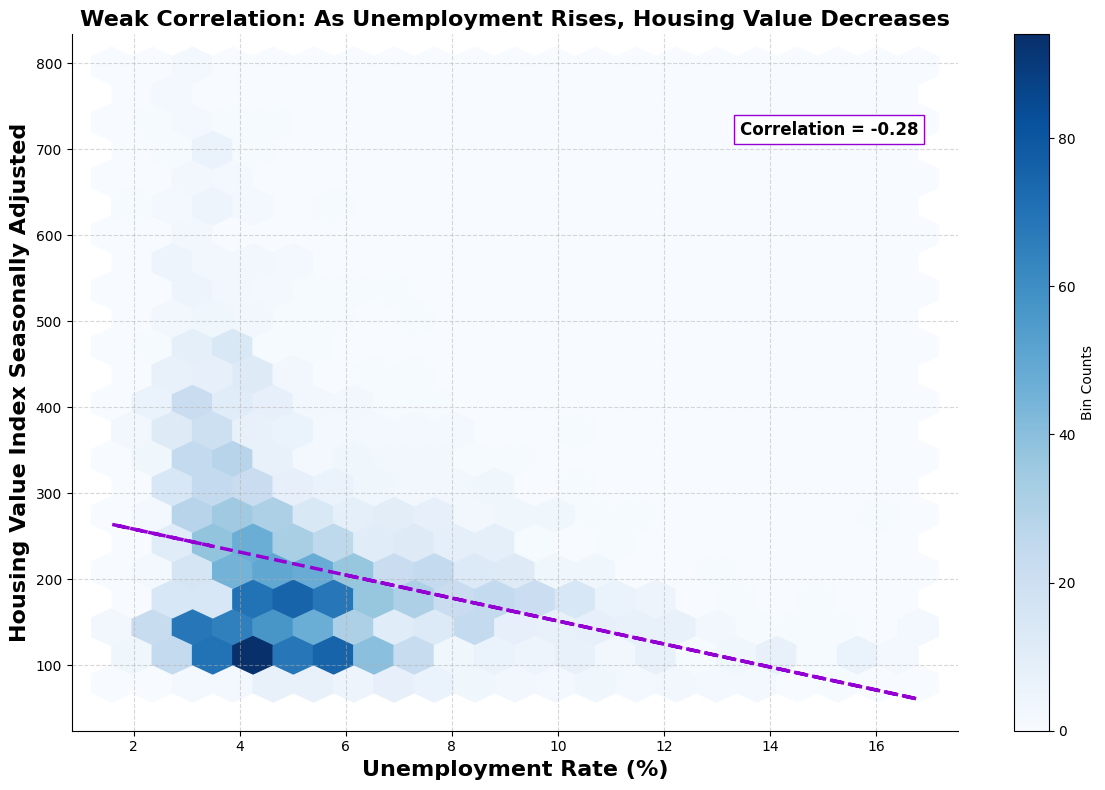

In [7]:
x = combined_tables_result['Unemployment_Rate']
y = combined_tables_result['Housing_value_Seasonally_Adjusted_Index']

correlation = x.corr(y).round(2)
slope, intercept = np.polyfit(x, y, 1)
y_fit = (slope * x) + intercept

fig, ax = plt.subplots(figsize=(12,8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Unemployment Rate (%)", fontweight='bold', fontsize=16)
ax.set_ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold', fontsize=16)
ax.set_title("Weak Correlation: As Unemployment Rises, Housing Value Decreases", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)
ax.plot(x, y_fit, color="darkviolet", linewidth=2.5, linestyle="--")
ax.text(
    x.max() * 0.80, 
    y.max() * 0.90, 
    f'Correlation = {correlation}',
    fontweight="bold", 
    fontsize=12, 
    bbox={'facecolor': 'white', 'edgecolor': 'darkviolet'}
    )

hb = ax.hexbin(x,y,gridsize=20, cmap='Blues')
fig.colorbar(hb, ax=ax, label='Bin Counts')
plt.tight_layout()
plt.show()

# What is the Correlation in the Louisville Metro Area?

### SQL Query for Louisville, KY

In [8]:
louisville_metro_area_query = """

SELECT 
    Unemployment.Year AS Unemployment_Year,
    Unemployment.Area AS Unemployment_Area,
    Unemployment.Employment AS Employment,
    Unemployment.Unemployment AS Unemployment,
    Unemployment.Unemployment_Rate AS Unemployment_Rate,
    Housing_value.Metro_Name AS Housing_value_Metro_Name,
    Housing_value.Seasonally_Adjusted_Index AS Housing_value_Seasonally_Adjusted_Index,
    Housing_value.CBSA AS Housing_value_cbsa
FROM Unemployment
INNER JOIN Housing_value
    ON Unemployment.FIPS_Code = Housing_value.CBSA
    AND Unemployment.Year = Housing_value.Year
WHERE Housing_value_cbsa = "31140"
"""

louisville_metro_area = pd.read_sql(louisville_metro_area_query, conn)

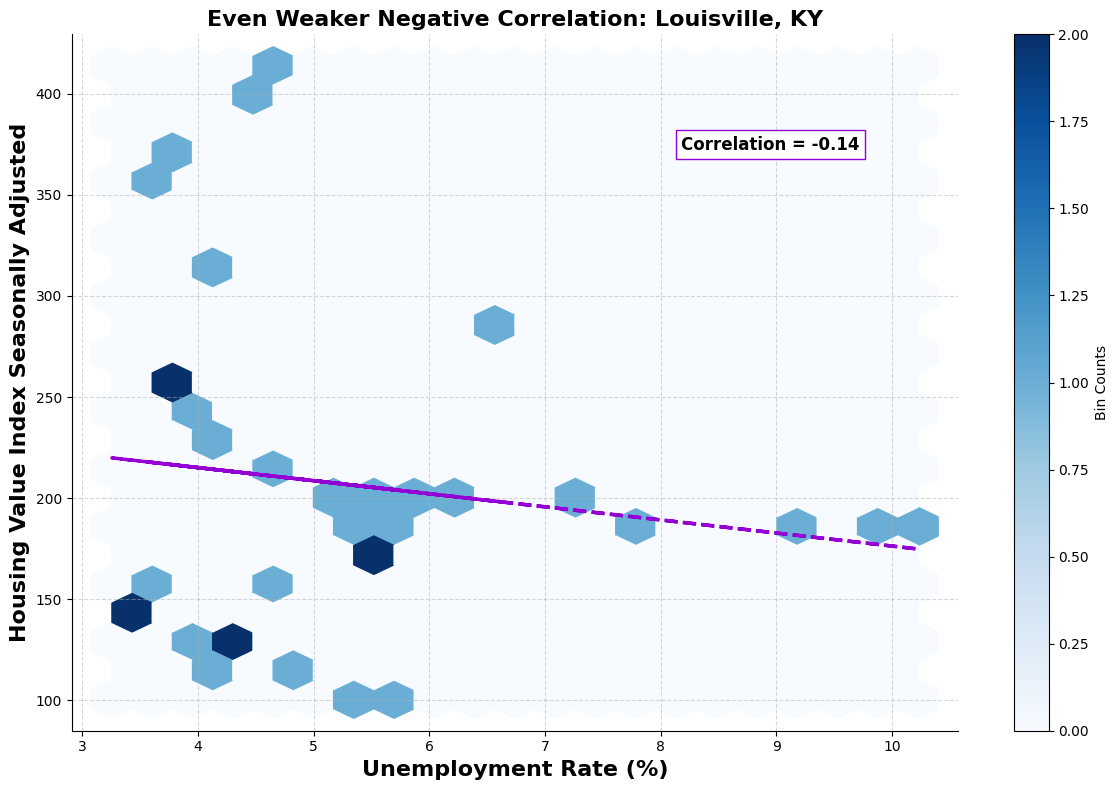

In [10]:
x = louisville_metro_area['Unemployment_Rate']
y = louisville_metro_area['Housing_value_Seasonally_Adjusted_Index']

correlation = x.corr(y).round(2)
slope, intercept = np.polyfit(x, y, 1)
y_fit = (slope * x) + intercept

fig, ax = plt.subplots(figsize=(12,8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Unemployment Rate (%)", fontweight='bold', fontsize=16)
ax.set_ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold', fontsize=16)
ax.set_title("Even Weaker Negative Correlation: Louisville, KY", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)
ax.plot(x, y_fit, color="darkviolet", linewidth=2.5, linestyle="--")
ax.text(
    x.max() * 0.80, 
    y.max() * 0.90, 
    f'Correlation = {correlation}',
    fontweight="bold", 
    fontsize=12, 
    bbox={'facecolor': 'white', 'edgecolor': 'darkviolet'}
    )

hb = ax.hexbin(x,y,gridsize=20, cmap='Blues')
fig.colorbar(hb, ax=ax, label='Bin Counts')
plt.tight_layout()
plt.show()